# Imports

In [81]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import timeit
from sklearn.neural_network import MLPClassifier
import re
import os
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import antropy as ant
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering
from scipy.fftpack import fft
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

# Functions

In [16]:
# Opg 1b
#######################################################################
def load_data_index(data_path: str, bearing: int, index: int) -> pd.DataFrame:
    """
    Load and filter data for a specific bearing and index from a CSV file.
    """
    index_file_path = f'{data_path}/{index}.csv'
    df_csv = pd.read_csv(index_file_path, delimiter=';')
    df_csv_filtered = df_csv[[col for col in df_csv.columns if str(bearing) in col]]
    return df_csv_filtered

def spectral_flatness(x: pd.Series) -> float:
    """
    Calculate the spectral flatness of a signal.
    """
    fft_spectrum = np.fft.fft(x)
    power_spectrum = np.abs(fft_spectrum)**2
    power_spectrum += 1e-10
    log_power_spectrum = np.log(power_spectrum)
    geometric_mean = np.exp(np.mean(log_power_spectrum))
    arithmetic_mean = np.mean(power_spectrum)
    return geometric_mean / arithmetic_mean

def spectral_centroid(signal, sr):
    """
    Calculate the spectral centroid of a signal.
    
    :param signal: The input signal.
    :param sr: The sampling rate of the signal.
    :return: The spectral centroid.
    """
    magnitude_spectrum = np.abs(fft(signal.to_numpy()))
    length = len(signal)
    freqs = np.fft.fftfreq(length, d=1/sr)
    
    # Only take the positive frequencies (first half of the spectrum)
    magnitude_spectrum = magnitude_spectrum[:length // 2]
    freqs = freqs[:length // 2]
    
    return np.sum(magnitude_spectrum * freqs) / np.sum(magnitude_spectrum)

def compute_bandwidth(signal, sr, power_threshold=0.95):
    """
    Calculate the bandwidth of a signal.
    
    :param signal: The input signal.
    :param sr: The sampling rate of the signal.
    :param power_threshold: The power threshold (default is 0.95).
    :return: The bandwidth of the signal.
    """
    # Compute the FFT and the Power Spectral Density (PSD)
    magnitude_spectrum = np.abs(fft(signal.to_numpy()))**2
    length = len(signal)
    freqs = np.fft.fftfreq(length, d=1/sr)
    
    # Only take the positive frequencies (first half of the spectrum)
    magnitude_spectrum = magnitude_spectrum[:length // 2]
    freqs = freqs[:length // 2]
    
    # Normalize the PSD to sum to 1 (relative power)
    psd_normalized = magnitude_spectrum / np.sum(magnitude_spectrum)
    
    # Compute the cumulative sum of the normalized PSD
    cumulative_power = np.cumsum(psd_normalized)
    
    # Find the frequency range where the cumulative power is within the power threshold
    lower_freq = freqs[np.searchsorted(cumulative_power, (1 - power_threshold) / 2)]
    upper_freq = freqs[np.searchsorted(cumulative_power, 1 - (1 - power_threshold) / 2)]
    
    # Bandwidth is the difference between the upper and lower frequencies
    bandwidth = upper_freq - lower_freq
    return bandwidth

def compute_roll_off(signal, sr, roll_off_threshold=0.707):
        magnitude_spectrum = np.abs(fft(signal.to_numpy()))
        length = len(signal)
        freqs = np.fft.fftfreq(length, d=1/sr)
        magnitude_spectrum = magnitude_spectrum[:length // 2]
        freqs = freqs[:length // 2]
        peak_magnitude = np.max(magnitude_spectrum)
        return freqs[np.where(magnitude_spectrum <= peak_magnitude * roll_off_threshold)[0][0]]

def get_features(df: pd.DataFrame) -> dict:
    """
    Extract statistical features from a DataFrame.
    """
    features = {
        'mean_x': df.iloc[:, 0].mean(),
        'mean_y': df.iloc[:, 1].mean(),
        'std_x': df.iloc[:, 0].std(),
        'std_y': df.iloc[:, 1].std(),
        'rms_x': np.sqrt(np.mean(df.iloc[:, 0]**2)),
        'rms_y': np.sqrt(np.mean(df.iloc[:, 1]**2)),
        'kurtosis_x': sp.kurtosis(df.iloc[:, 0]),
        'kurtosis_y': sp.kurtosis(df.iloc[:, 1]),
        'variance_x': df.iloc[:, 0].var(),
        'variance_y': df.iloc[:, 1].var(),
        'crest_factor_x': np.max(np.abs(df.iloc[:, 0])) / np.sqrt(np.mean(df.iloc[:, 0]**2)),
        'crest_factor_y': np.max(np.abs(df.iloc[:, 1])) / np.sqrt(np.mean(df.iloc[:, 1]**2)),
        'skewness_x': sp.skew(df.iloc[:, 0]),
        'skewness_y': sp.skew(df.iloc[:, 1]),
        'spectral_flatness_x': spectral_flatness(df.iloc[:, 0]),
        'spectral_flatness_y': spectral_flatness(df.iloc[:, 1]),
        'sample_entropy_x': ant.sample_entropy(df.iloc[:, 0]),
        'sample_entropy_y': ant.sample_entropy(df.iloc[:, 1]),
        'peak_value_x': np.max(np.abs(df.iloc[:, 0])),
        'peak_value_y': np.max(np.abs(df.iloc[:, 0])),
        'spectral_centroid_x': spectral_centroid(df.iloc[:, 0], 20480),
        'spectral_centroid_y': spectral_centroid(df.iloc[:, 1], 20480),
        'bandwidth_x': compute_bandwidth(df.iloc[:, 0], 20480),
        'bandwidth_y': compute_bandwidth(df.iloc[:, 1], 20480),
        'roll_off_x': compute_roll_off(df.iloc[:, 0], 20480),
        'roll_off_y': compute_roll_off(df.iloc[:, 1], 20480)
    }
    return features

def process_file(data_path: str, bearing: int, index: int) -> pd.DataFrame:
    """
    Process a single file and extract features.
    """
    df = load_data_index(data_path, bearing, index)
    features = get_features(df)
    features['index'] = index
    return pd.DataFrame(features, index=[index])

def generate_dataset(data_path: str, bearing=4) -> pd.DataFrame:
    """
    Generate a dataset by loading, processing, and extracting features from CSV files.
    """
    data_length = find_highest_number_in_filenames(data_path)
    if data_length is None:
        return pd.DataFrame()
    
    dataframe_list = []
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_file, data_path, bearing, index): index for index in range(data_length + 1)}
        for future in tqdm(as_completed(futures), total=data_length + 1, desc="Processing files"):
            dataframe_list.append(future.result())
    
    df = pd.concat(dataframe_list)
    df = df.sort_index()
    classification = pd.read_csv(f'{data_path}/bearing_conditions.csv', delimiter=';')
    dataset = pd.concat([df, classification], axis=1)
    dataset.set_index('index', inplace=True)
    
    return dataset

def find_highest_number_in_filenames(folder_path: str) -> int:
    """
    Find the highest numerical filename in a folder.
    """
    files = os.listdir(folder_path)
    pattern = re.compile(r'^(\d+)\.csv$')
    numbers = [int(pattern.match(file).group(1)) for file in files if pattern.match(file)]
    return max(numbers) if numbers else None

def plot_scatter_matrix(df: pd.DataFrame) -> None:
    """
    Plot a scatter matrix of the DataFrame.
    """
    sns.pairplot(df, hue='b4_state')
    plt.show()
    

# Opdracht 1

## 1a

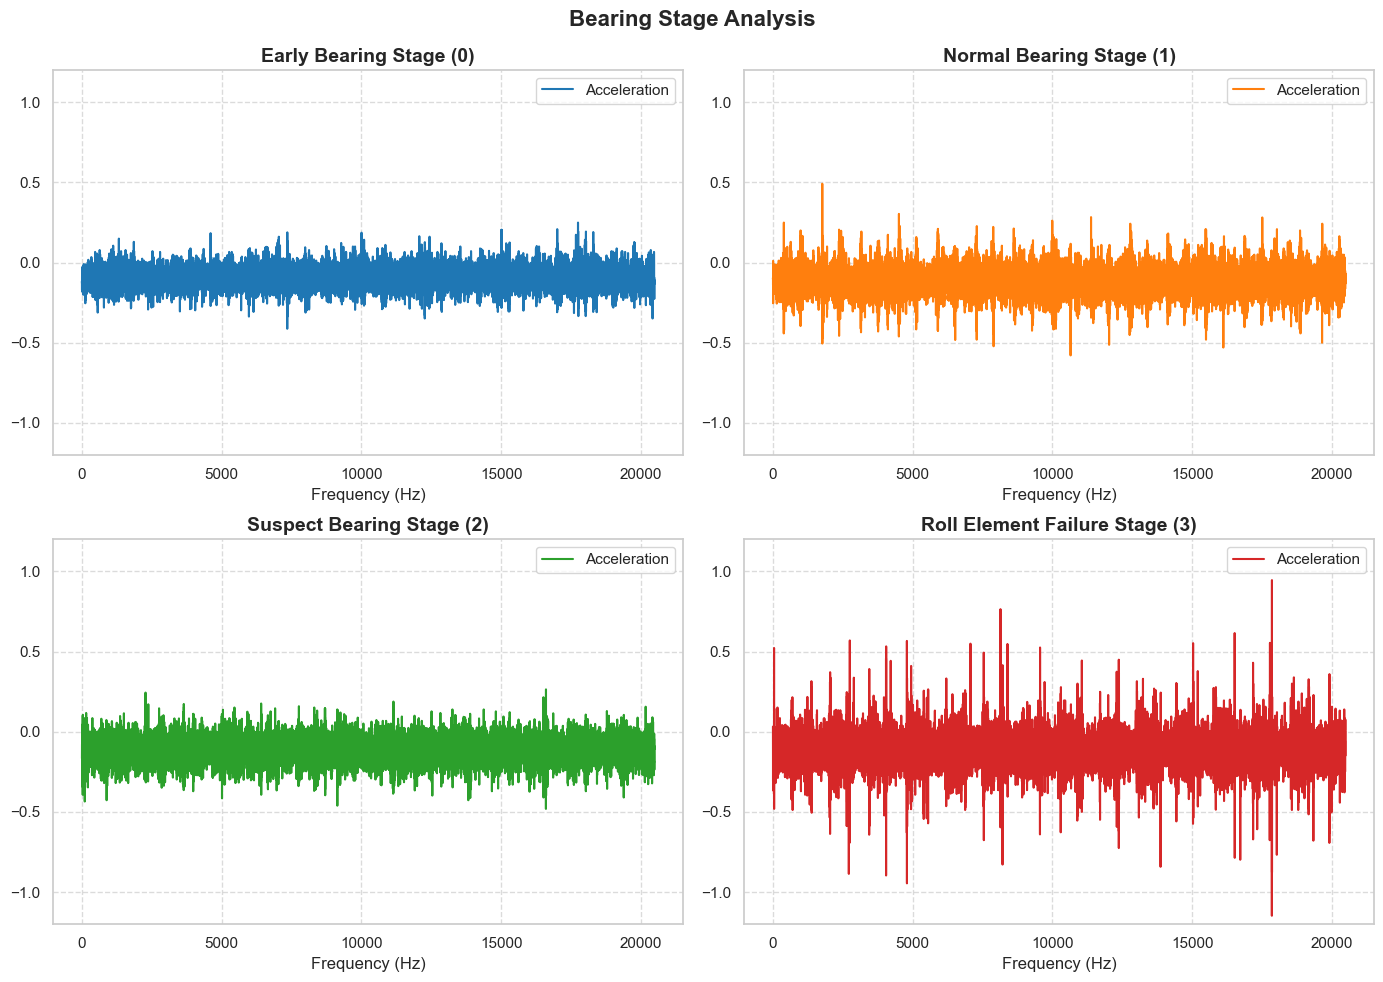

In [3]:
# import samples from different degredation stages 
df_0 = pd.read_csv('data/0.csv',sep=';') #stage 0
df_200 = pd.read_csv('data/200.csv',sep=';') # stage 1
df_900 = pd.read_csv('data/900.csv',sep=';') # stage 2
df_1300 = pd.read_csv('data/1300.csv',sep=';') # stage 3

# Set the style
sns.set(style="whitegrid")

# Create a figure and 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Define a common y-axis limit
y_limits = [-1.2, 1.2]

# Define titles and data
titles = [
    'Early Bearing Stage (0)',
    'Normal Bearing Stage (1)',
    'Suspect Bearing Stage (2)',
    'Roll Element Failure Stage (3)'
]
data_frames = [df_0, df_200, df_900, df_1300]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each DataFrame on a different subplot
for ax, title, df, color in zip(axs.flatten(), titles, data_frames, colors):
    ax.plot(range(0, len(df)), df.b4x, color=color, linewidth=1.5, label='Acceleration')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylim(y_limits)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout
plt.tight_layout()

# Add a main title
fig.suptitle('Bearing Stage Analysis', fontsize=16, weight='bold')
plt.subplots_adjust(top=0.92)

# save figure to png
#plt.savefig('plot_ex_1a.png')

plt.show()

## 1b

### Create dataset with features.

In [4]:
# generate dataset with features:
data_path = 'data'
dataset = generate_dataset(data_path)

# Export to excel
dataset.to_excel('dataset_features.xlsx')

Processing files:  21%|██        | 359/1724 [00:46<02:58,  7.64it/s]


In [7]:
dataset.head(10)

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,kurtosis_x,kurtosis_y,variance_x,variance_y,crest_factor_x,crest_factor_y,skewness_x,skewness_y,spectral_flatness_x,spectral_flatness_y,sample_entropy_x,sample_entropy_y,b4_state
index,,,,,,,,,,,,,,,,,,,
0,-0.090969,-0.094235,0.060086,0.066382,0.109020,0.115267,0.790250,1.807990,0.003610,0.004407,3.788279,4.086150,0.046609,0.008295,0.096071,0.145048,1.882153,1.963611,0
1,-0.091260,-0.087946,0.059421,0.064746,0.108900,0.109208,1.234703,1.873189,0.003531,0.004192,3.856767,5.741343,0.085164,-0.053792,0.091647,0.148553,2.017231,1.977537,0
2,-0.092597,-0.093106,0.059969,0.065255,0.110319,0.113696,0.924708,1.429695,0.003596,0.004258,3.589583,5.286029,0.009609,0.047138,0.089017,0.139277,2.033446,1.976102,0
3,-0.093485,-0.093244,0.059917,0.066303,0.111037,0.114413,0.652667,1.378184,0.003590,0.004396,3.539356,4.588643,-0.037259,0.021106,0.090138,0.140414,2.050200,1.988273,0
4,-0.104769,-0.093042,0.058607,0.065404,0.120046,0.113729,0.687223,1.128042,0.003435,0.004278,3.332048,3.780924,0.006678,-0.005512,0.075905,0.142373,2.027120,1.988056,0
5,-0.018549,-0.092251,0.063495,0.064713,0.066148,0.112684,0.614170,1.238299,0.004032,0.004188,5.019068,4.135444,-0.013040,-0.068305,0.250295,0.138438,1.910480,1.983077,0
6,-0.099928,-0.092892,0.058408,0.064928,0.115745,0.113333,0.868311,1.484047,0.003411,0.004216,3.438604,4.694145,0.023816,-0.014279,0.079909,0.138747,2.007273,1.982731,0
7,-0.056903,-0.092785,0.060297,0.064233,0.082907,0.112849,0.807403,1.515045,0.003636,0.004126,4.679950,4.475021,-0.081036,0.043939,0.157589,0.139677,1.874582,1.991523,0
8,-0.079501,-0.092462,0.059827,0.065976,0.099496,0.113587,0.957008,1.220830,0.003579,0.004353,3.980067,4.084984,-0.026472,0.029973,0.110134,0.143864,2.020190,1.968761,0


In [8]:
for i in range(0, 5):
    var = dataset[dataset.b4_state == i]['spectral_flatness_x'].mean()
    print(f'state: {i}: {var}')

state: 0: 0.10443083401477793
state: 1: 0.09431637719718174
state: 2: 0.09095162507877823
state: 3: 0.13833851373824396
state: 4: 0.16513563791150435


Kurtosis: Meet de 'tailedness' van de kans verdeling van het signaal, dat wil zeggen dat bij een hoge kurtosis in de data kan aangeven dat er grote schokken of grote afwijkingen zijn die mogelijk beschadigde bearings kan aangeven.

Skewness: Meet de assymmetrie van de kans verdeling van het signaal. Dus verandering in skewness kan een aanwijzing zijn dat er verschuiving in signaal gedrag plaats vind. Bij nader inzien is deze features toch niet zo handig, omdat dit dus een verandering kan aangeven, maar we kijken in de voorspelling naar elk punt apart. Terwijl skewness alleen veranderd als je van de ene toestand naar gaat. dus skewness is bijvoorbeeld wel handig bij live data, waarbij je een verandering in skewness kan vastleggen.

Spectral Flatness: Geeft aan hoe puur het signaal is, als deze waarde laag is wil dat zeggen de meeste amplitude van het signaal in een paar frequenties zit. En bij een hoge waarde heeft het signaal een meer uniform verdeelde amplitude over veel frequenties, veel ruis dus.

Crest factor: De crest factor is de grootste piek in het signaal gedeeld door de gemiddelde amplitude van het signaal. Als deze factor hoog is heeft het signaal hoge pieken.

Sample entropy: Geeft complexiteit en irregulariteit aan. Dus hoe onvoorspelbaar het signaal is. Bij een hoge waarde is er een minder herhaaldelijk signaal. Bij een lagere waarde is het een meer herhaadelijk signaal.

## 1c

In [31]:
dataset.describe()

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,kurtosis_x,kurtosis_y,variance_x,variance_y,crest_factor_x,crest_factor_y,skewness_x,skewness_y,spectral_flatness_x,spectral_flatness_y,sample_entropy_x,sample_entropy_y,b4_state
count,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000
mean,-0.112702,-0.112563,0.091589,0.095079,0.146580,0.148372,2.136559,2.198934,0.009184,0.009674,4.803214,4.990876,0.014464,0.027285,0.113047,0.176176,1.853428,1.960467,1.911253
std,0.007799,0.007629,0.028206,0.025189,0.021456,0.019702,3.584039,3.453004,0.006194,0.005541,1.879905,1.881544,0.088909,0.085765,0.031693,0.043306,0.107741,0.084348,1.225437
min,-0.176678,-0.192129,0.058208,0.064233,0.062242,0.098785,0.430880,0.536752,0.003388,0.004126,3.004100,3.007487,-0.996255,-1.052101,0.053793,0.069320,1.376152,1.539494,0.000000
25%,-0.114878,-0.114814,0.073136,0.079124,0.135612,0.138661,0.895612,1.052083,0.005349,0.006261,3.752244,4.019841,-0.026154,-0.006623,0.090913,0.146294,1.825533,1.944242,1.000000
50%,-0.114313,-0.114121,0.079290,0.083047,0.139089,0.141234,1.264476,1.350348,0.006287,0.006897,4.166289,4.385269,0.008633,0.024188,0.097096,0.157976,1.874096,1.986731,2.000000
75%,-0.113839,-0.113374,0.102013,0.106390,0.154938,0.158714,1.777781,1.899337,0.010407,0.011320,4.999732,5.079944,0.048840,0.060865,0.129998,0.190207,1.931050,2.009448,3.000000
max,-0.015861,-0.058019,0.204396,0.181060,0.234522,0.213875,71.554256,56.367171,0.041778,0.032783,19.449327,19.173927,2.156965,1.076500,0.287744,0.303962,2.050200,2.105115,4.000000


In [32]:
dataset['b4_state'].value_counts()

b4_state
1    635
2    347
3    334
4    241
0    167
Name: count, dtype: int64

### Correlatie matrix

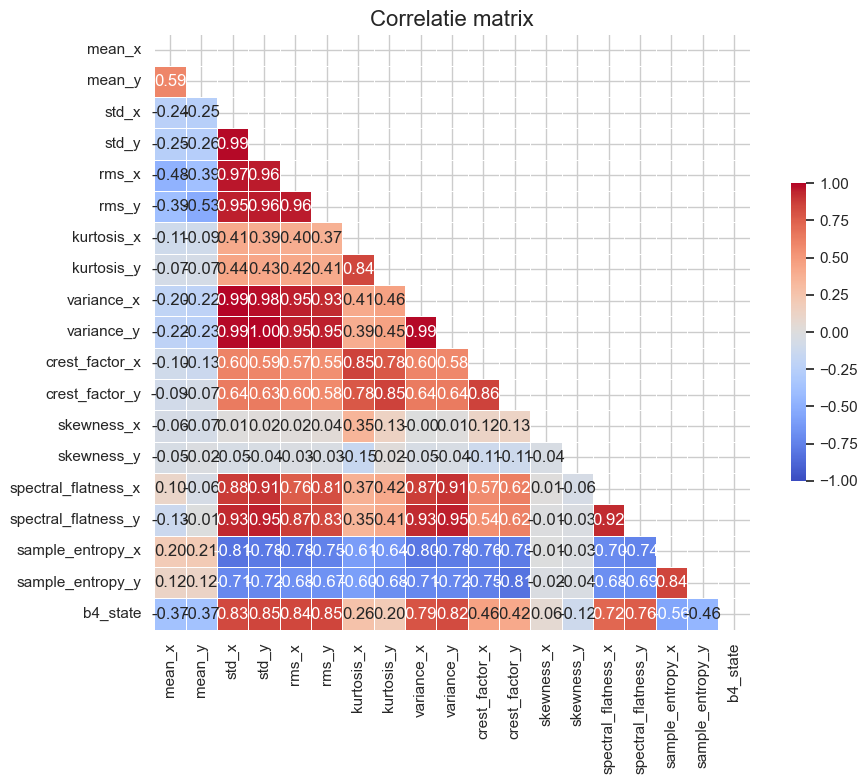

In [9]:
dataset = pd.read_excel('dataset_features.xlsx').drop(columns='index')
corr = dataset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, ax=ax, cbar_kws={"shrink": .5})

plt.title("Correlatie matrix", fontsize=16)
plt.tight_layout()
plt.show()

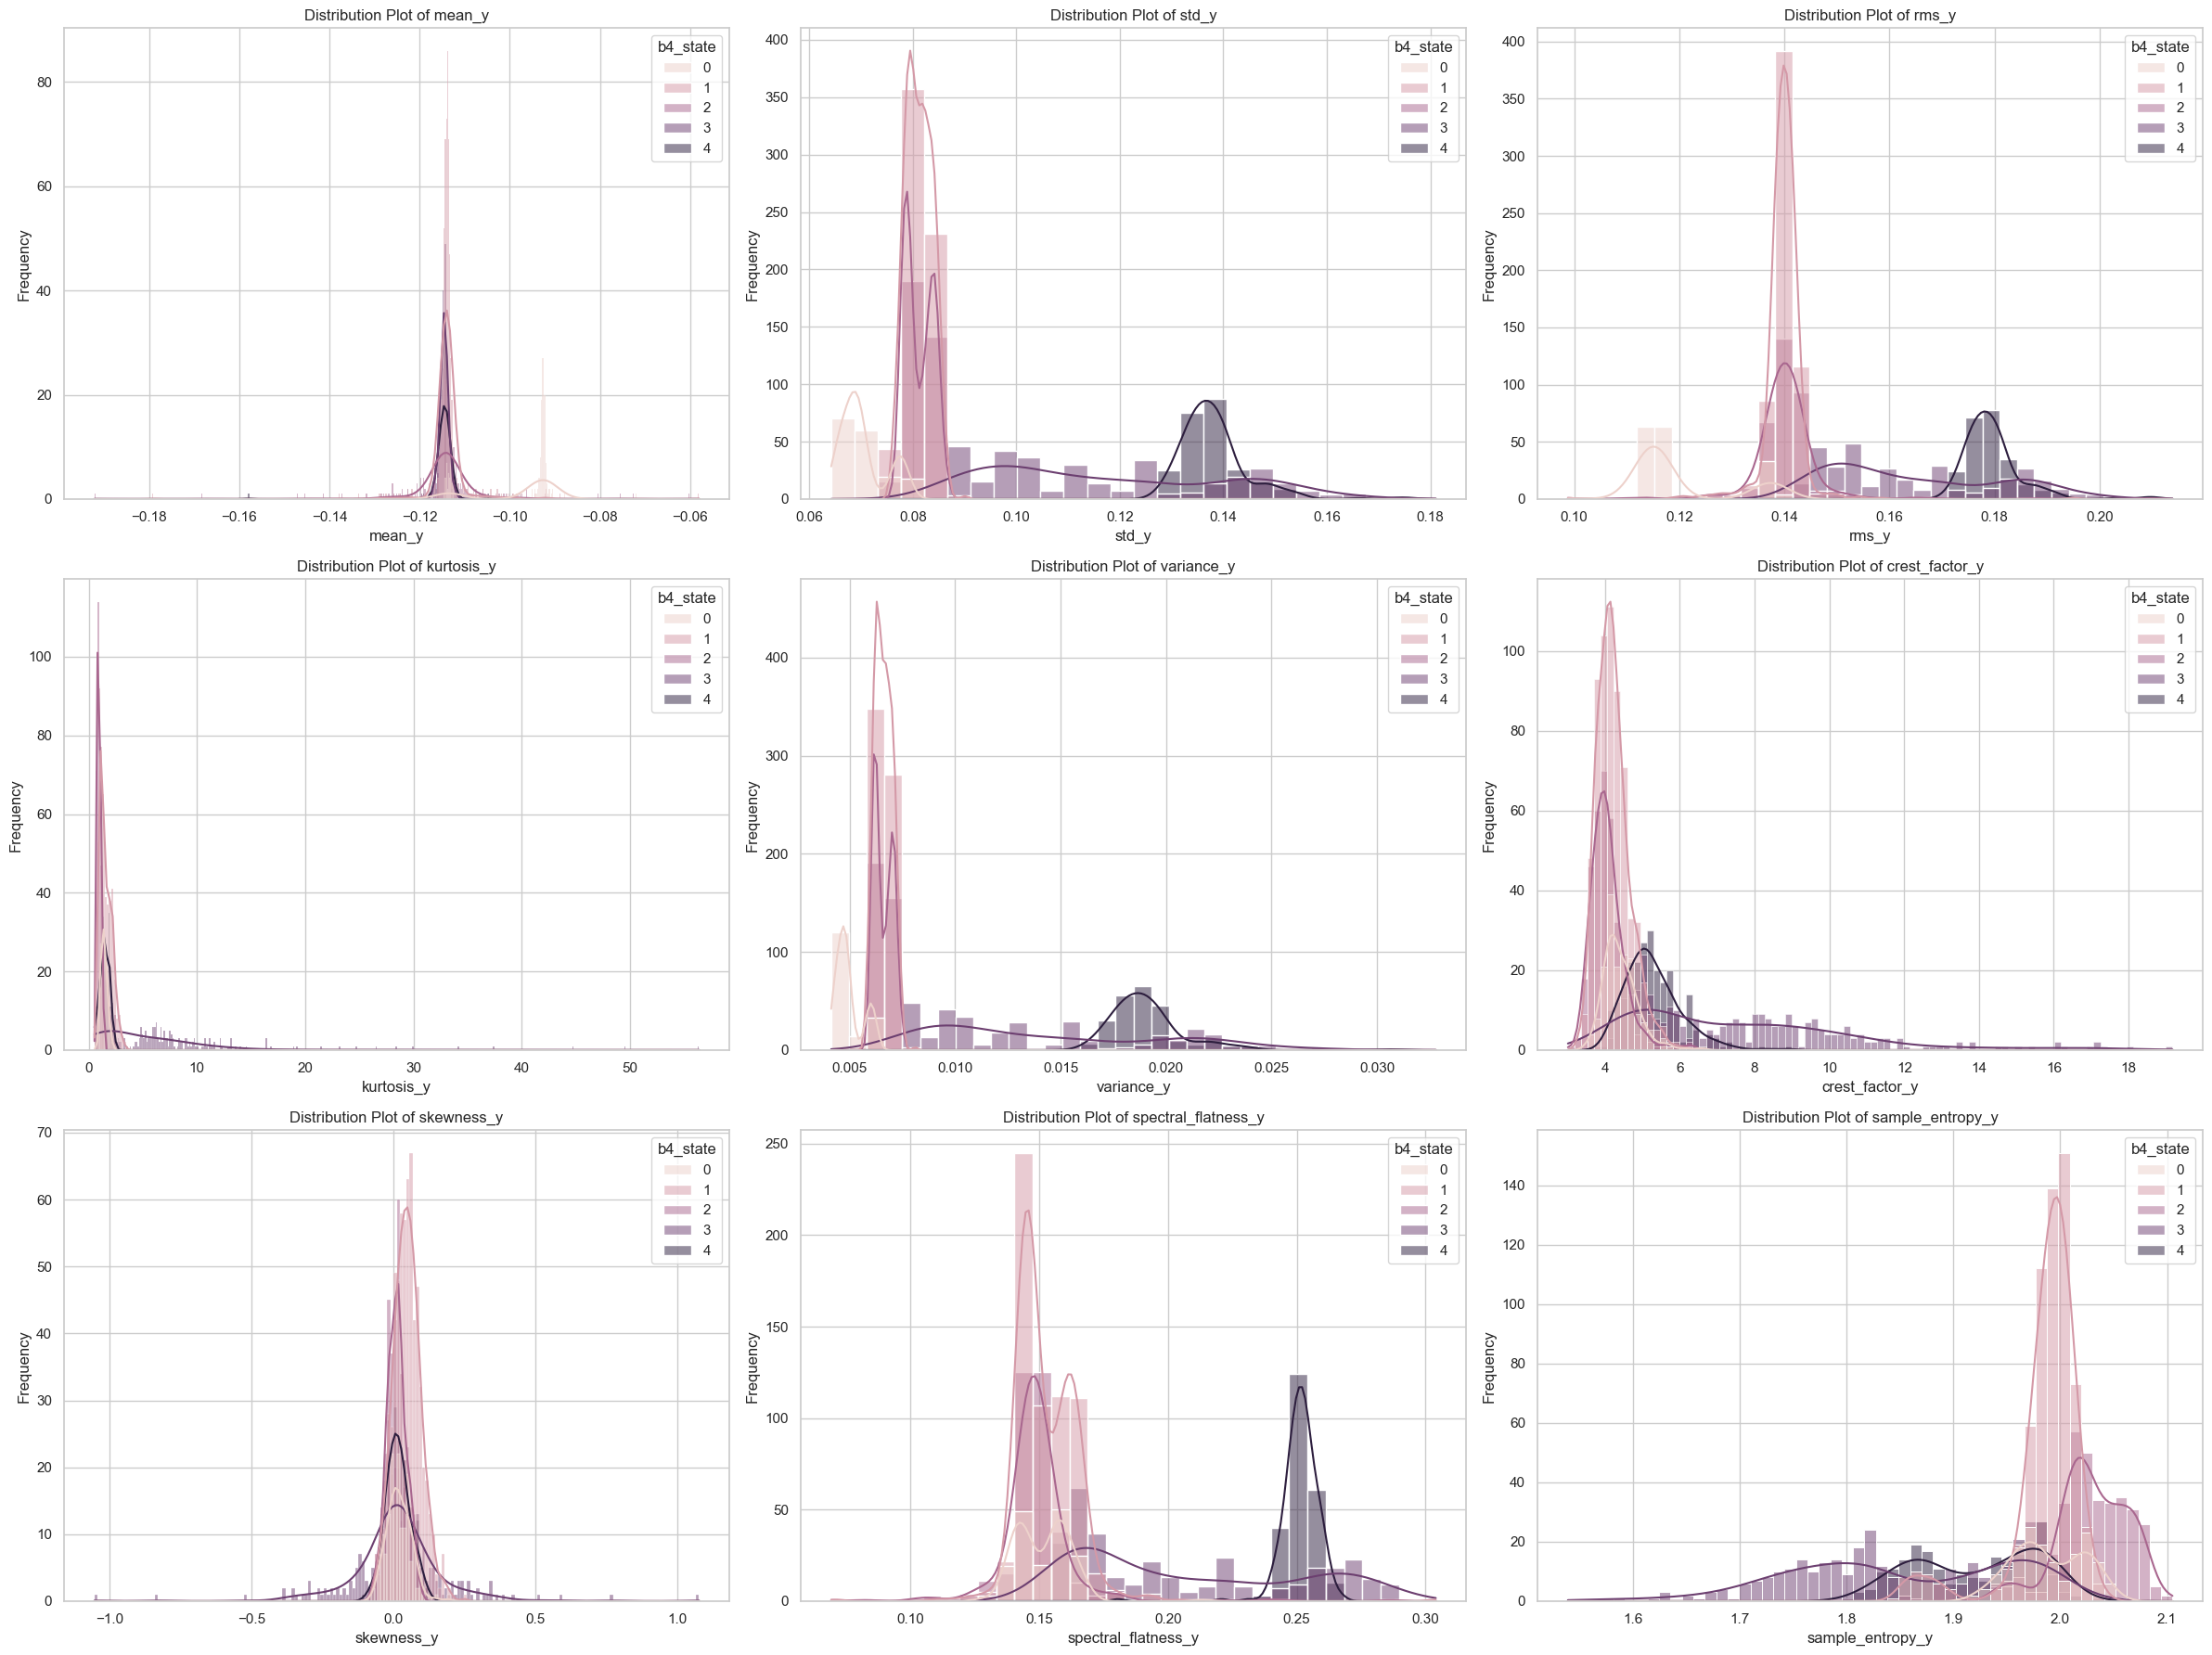

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your list of columns
columns_with_y = ['mean_y', 'std_y', 'rms_y', 'kurtosis_y', 'variance_y', 'crest_factor_y', 'skewness_y', 'spectral_flatness_y', 'sample_entropy_y']

# Determine the number of rows needed (3 columns per row)
n_cols = 3
n_rows = (len(columns_with_y) + n_cols - 1) // n_cols  # Ceiling division

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the columns and plot each histogram with hue based on wear state
for i, column in enumerate(columns_with_y):
    sns.histplot(data=dataset, x=column, hue='b4_state', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


Op basis van bovenstaande histogrammen denk ik dat sample entropy het beste is om mee te nemen naast spectral entropy, vooral omdat de sample entropy het verschil tussen de failure stage 1 and de normal en suspect stage goed laat zien. Dus nuttig om naast de spectal entropy erbij te zetten voor extra bearing stage onderscheiding.

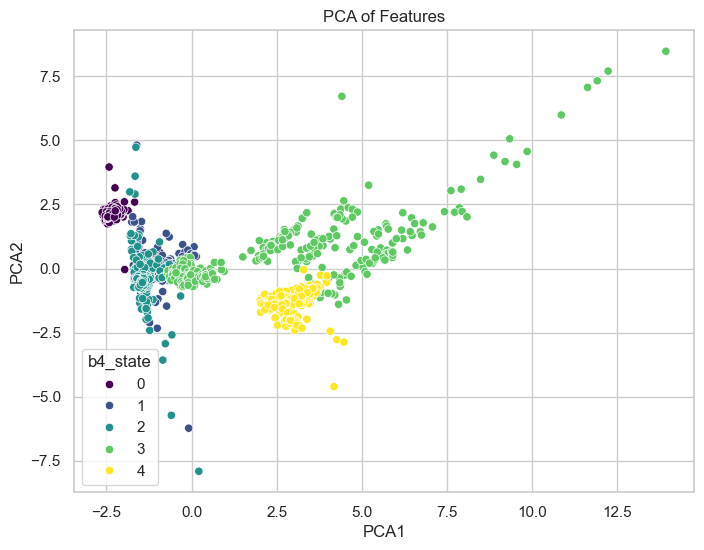

In [23]:
# PCA Analysis
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[['mean_y', 'std_y', 'rms_y', 'kurtosis_y', 'variance_y', 'crest_factor_y', 'skewness_y', 'spectral_flatness_y', 'sample_entropy_y']])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['b4_state'] = dataset['b4_state']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='b4_state', data=pca_df, palette='viridis')
plt.title('PCA of Features')
plt.show()

Kijkend naar de grafieken hierboven, kan een LDA geschikt zijn om onderscheid te maken tussen fase 4 en de rest van de fasen. Maar voor de andere klassen is dat moeilijker. Voor de rest kan een RandomForest Classifier of een vergelijkbare op decisiontree gebaseerde classifier geschikt zijn. En kijkend naar de PCA, zou een niet-lineaire SVM geschikt kunnen zijn. Maar de overlap tussen fase 1 en 2 is misschien te groot daarvoor. En misschien zou een neuraal netwerk zoals een Multi-Layer Perceptron kunnen werken.

## 1d

$$\text{RMS} = \sqrt{\frac{\sum^n_{i = 1}{x^2_i}}{n}}$$
$$\sigma = \sqrt{\frac{\sum^n_{i = 1}{(x_i - \mu)^2}}{n}}$$
$$\sigma^2 = \frac{\sum^n_{i = 1}{(x_i - \mu)^2}}{n}$$
$$\sigma^2 = \frac{1}{n} \cdot \sum^n_{i = 1}{(x_i - \mu)^2} $$
$$\sigma^2 = \frac{1}{n} \cdot \sum^n_{i = 1}{x_i^2 - \mu^2} $$
$$\sigma = \sqrt{\frac{1}{n} \cdot \sum^n_{i = 1}{x_i^2 - \mu^2}} = \sqrt{(RMS^2 - \mu^2)} $$

Dus als $\mu \approx 0 $, dan is $\sigma \approx \text{RMS}$

En de acceleration data van de samples in dataset zitten gemiddeld vrij dicht op de 0 en veranderen tussen samples niet veel dus dat verklaard de hoge correlatie. Omdat de $\mu^2$ dus ongeveer gelijk blijft, maar de RMS wel mee veranderd is de $\sigma \propto RMS$ en vandaar dus ook die hoge correlatie van tegen de 1.0. Hierom zullen we de standaard deviatie achterwege laten en de RMS gebruiken in het model.

## 1e

### (1)

In [47]:
dataset = pd.read_excel('dataset_features.xlsx')
X_vert = dataset[['mean_y', 'rms_y', 'variance_y', 'spectral_flatness_y', 'sample_entropy_y']]
X_hor = dataset[['mean_x', 'rms_x', 'variance_x', 'spectral_flatness_x', 'sample_entropy_x']]
X = dataset[['mean_x', 'mean_y', 'rms_x', 'rms_y', 'variance_x', 'variance_y', 'spectral_flatness_x', 'spectral_flatness_y', 'sample_entropy_x', 'sample_entropy_y']]
y = dataset['b4_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
def confusion_matrix_plot(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Early', 'Predicted Normal', 'Predicted Suspect', 'Predicted Failure 1', 'Predicted Failure 2'], yticklabels=['True Early', 'True Normal', 'True Suspect', 'True Failure 1', 'True Failure 2'])

#### LDA model

Mean Squared Error (MSE): 0.23768115942028986
Adjusted R^2: 0.8334647577273436


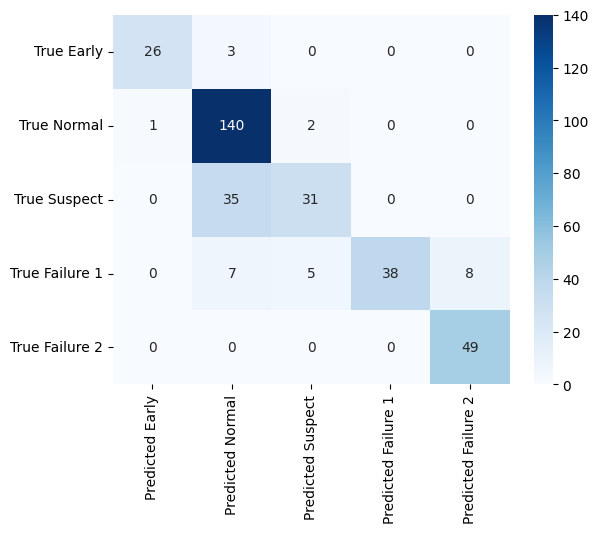

In [53]:
n = len(y_test)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Adjusted R^2: {r2_adj}")

confusion_matrix_plot(y_test, y_pred)

#### Random Forest classification model

100%|██████████| 20/20 [02:26<00:00,  7.30s/it]


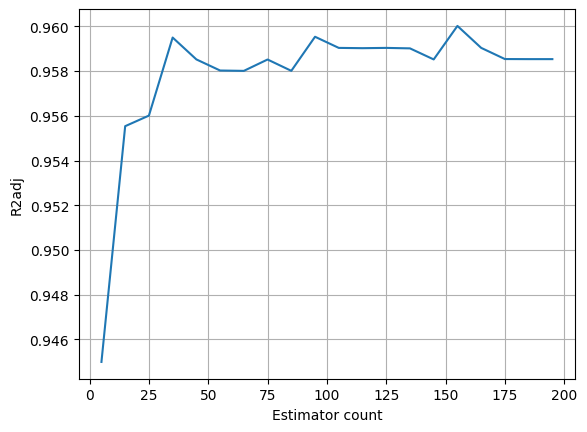

In [50]:
def R2_adj(estimator, x, y_true):
    n, p = x.shape
    y_pred = estimator.predict(x)
    r2 = r2_score(y_true, y_pred)
    return 1 - ((1 - r2) * (n - 1))/(n-p-1)

param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20, 40, 80, 160, 320]
}

RF_regressor = RandomForestClassifier(n_estimators=20)
grid_search_RF_Regressor = GridSearchCV(RF_regressor, param_grid, cv=5, scoring=R2_adj, n_jobs=-1)
grid_search_RF_Regressor.fit(X_train, y_train)

R2adj = []
n_est_idx = range(5, 200, 10)

for n_est in tqdm(n_est_idx, total=len(n_est_idx)):
    RF_regressor = RandomForestClassifier(n_estimators=n_est, random_state=42)
    grid_search_RF_Regressor = GridSearchCV(RF_regressor, param_grid, cv=5, scoring=R2_adj, n_jobs=-1)
    grid_search_RF_Regressor.fit(X_train, y_train)
    R2adj.append(grid_search_RF_Regressor.best_score_)

plt.plot(n_est_idx, R2adj)
plt.xlabel('Estimator count')
plt.ylabel('R2adj')
plt.grid()
plt.show()

Op basis van bovenstaand grafiek is 35 estimators de beste optie, aangezien de R2adj niet veel verbeterd en meer afvlakt naarmate er meer estimators worden gebruikt.

{'max_depth': None, 'min_samples_split': 2} 0.9594978337677411 RandomForestClassifier(n_estimators=35, random_state=42)
Mean Squared Error: 0.06086956521739131
R-squared adjusted: 0.9573507306374904


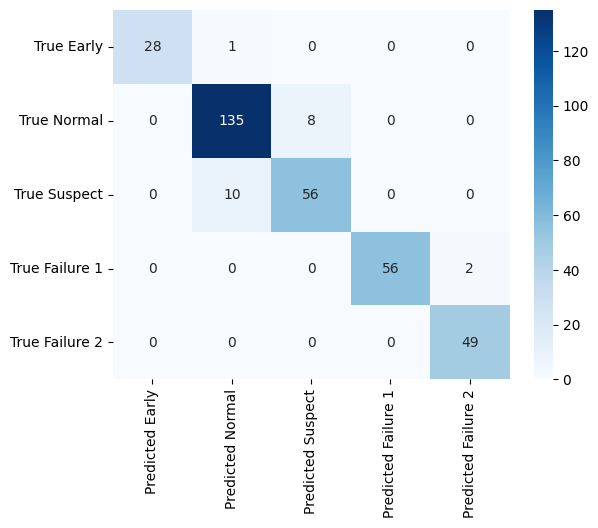

In [52]:
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20, 40, 80, 160, 320]
}

RF_regressor_best = RandomForestClassifier(n_estimators=35, random_state=42)
grid_search_RF_Regressor_best = GridSearchCV(RF_regressor_best, param_grid, cv=5, scoring=R2_adj, n_jobs=-1)
grid_search_RF_Regressor_best.fit(X_train, y_train)

print(grid_search_RF_Regressor_best.best_params_, grid_search_RF_Regressor_best.best_score_, grid_search_RF_Regressor_best.best_estimator_)
y_pred = grid_search_RF_Regressor_best.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2adj = R2_adj(grid_search_RF_Regressor_best.best_estimator_, X_test, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared adjusted: {r2adj}")
confusion_matrix_plot(y_test, y_pred)

Deze RandomTreeClassifier geeft al een $R^2_{adj}$ van $0.9573$, wat al beter is dan de LDA die we eerder getrained hadden die een $R^2_{adj}$ van $0.8334$. En de MSE van de RTC is ook vrij laag namelijk: 0.0608. Dit alles geeft aan dat het model goed generaliseerd en goed reageerd op nieuwe data. En dus 95.73% van de variantie kan worden uitgelegd door het model. In de confusion matrix kunnen we ook zien dat dit model een stuk minder fouten maakt met het onderscheiden van Suspect en normal.

Mean Squared Error: 0.14202898550724638
R-squared adjusted: 0.9004850381541444


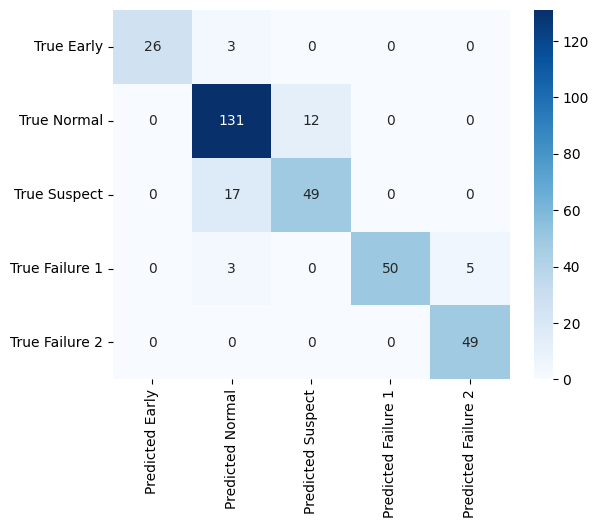

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', random_state=42) 
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error: {mse}")
print(f"R-squared adjusted: {r2_adj}")
confusion_matrix_plot(y_test, y_pred)

Based on the MSE and R^2 this model isn't better then the RandomForest Classifier, but is better then the LDA. This mainly ccomes down to what model can better differentiate between the suspect and normal bearing stages. And the randomforestclassifier is the best one right now.

### Multi-layer Perceptron Classifier

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Luukh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: {'hidden_layer_sizes': (5, 5, 5, 5, 5)}
Best cross-validation accuracy: 0.8484347826086956
Mean Squared Error: 0.14492753623188406
R-squared adjusted: 0.8996558469492942


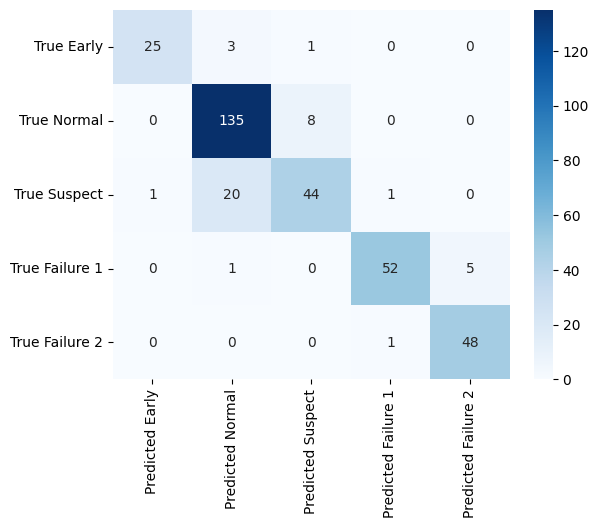

In [78]:
clf = MLPClassifier(solver='adam', batch_size=32,  max_iter=100, alpha=1e-5, hidden_layer_sizes=(11, 8, 6), random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for hidden layers
layer_range = range(5, 11)
param_grid = {
    'hidden_layer_sizes': [
        layer_combination
        for num_layers in range(1, 6)
        for layer_combination in itertools.product(layer_range, repeat=num_layers)
    ]
}

# Instantiate the MLPClassifier
clf = MLPClassifier(solver='adam', batch_size=32, max_iter=100, alpha=1e-5, random_state=42)

# Use GridSearchCV to find the best hidden layer setup
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Use the best estimator to make predictions on the test set
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

p = X_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Mean Squared Error: {mse}")
print(f"R-squared adjusted: {r2_adj}")
confusion_matrix_plot(y_test, y_pred)

In [68]:
X_train

,mean_x,mean_y,rms_x,rms_y,variance_x,variance_y,spectral_flatness_x,spectral_flatness_y,sample_entropy_x,sample_entropy_y
1635,-0.113652,-0.114120,0.167745,0.174415,0.015222,0.017398,0.172847,0.247559,1.881191,1.963745
1073,-0.115567,-0.106760,0.143416,0.136426,0.007213,0.007215,0.091463,0.167758,1.920220,2.080653
1473,-0.116022,-0.114809,0.181227,0.180586,0.019383,0.019431,0.168793,0.260000,1.726006,1.835426
806,-0.115571,-0.114967,0.136649,0.138785,0.005316,0.006044,0.087523,0.142932,1.972696,2.015020
1027,-0.113824,-0.147146,0.141461,0.169330,0.007056,0.007021,0.092213,0.105579,1.888007,2.053606
...,...,...,...,...,...,...,...,...,...,...
1130,-0.114700,-0.115192,0.139118,0.142997,0.006198,0.007179,0.098172,0.151728,1.926229,2.105115
1294,-0.114924,-0.115162,0.155448,0.158652,0.010957,0.011909,0.141945,0.190119,1.788025,1.930383
860,-0.114804,-0.114970,0.135754,0.139246,0.005249,0.006172,0.089270,0.145058,1.973946,2.028942
1459,-0.114174,-0.114109,0.189912,0.184206,0.023032,0.020912,0.167582,0.261722,1.669216,1.840311


# Opdracht 2

#### Opdracht 2a, test train split data maken

In [37]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("shaft_radius.csv", sep=',')
y = df.shaft_radius
x = df.measurement_index

x_train = x[:int(len(x)*0.8)].tolist()
x_test = x[int(len(x)*0.8):].tolist()
y_train = y[:int(len(y)*0.8)].tolist()
y_test = y[int(len(y)*0.8):].tolist()

#### Opdracht 2b, model maken

##### Om te kijken of lineare regressie toereikend is plotten we eerst de x t.o.v. de y. Als hier een redelijk linear verband in te vinden is kunnen we lineare regressie toepassen


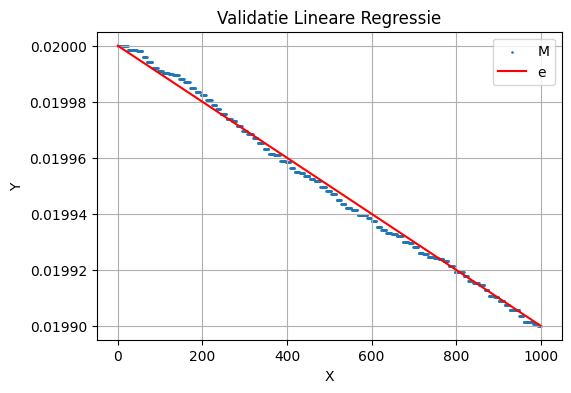

In [43]:
plt.figure(figsize=[6,4])
plt.scatter(x,y, s=0.75)
plt.plot([min(x), max(x)], [max(y), min(y)], color='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend('Meting')
plt.title("Validatie Lineare Regressie")
plt.grid()
plt.show()

#### Zoals we hierboven kunnen zien is er een vrijwel linear verband tussen X en Y. Daarom kiezen voor een Linear Regressie model. Hiervoor kiezen we OLS.

In [40]:
model = sm.OLS(y_train,x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              2378.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):                   1.13e-241
Time:                        12:17:53   Log-Likelihood:                          2548.2
No. Observations:                 800   AIC:                                     -5094.
Df Residuals:                     799   BIC:                                     -5090.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.742e-05   7.67e-07     48.760      0.000    3.59e-05    3.89e-05
==============================================================================
Omnibus:                      565.948   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.025
Skew:                           0.000   Prob(JB):                     3.73e-11
Kurtosis:                       1.800   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Opdracht 3

## 3a

In [17]:
dataset = generate_dataset('data', 1)
dataset.to_excel('dataset_features_b1.xlsx')

Processing files: 100%|████████████████████████████████████████████████████████████| 1724/1724 [03:23<00:00,  8.48it/s]


In [6]:
dataset.to_excel('dataset_features_b1.xlsx')

In [126]:
df = pd.read_excel('dataset_features_b1.xlsx')
X = df[['mean_x', 'mean_y', 'rms_x', 'rms_y', 'spectral_flatness_x', 'spectral_flatness_y', 'sample_entropy_x', 'sample_entropy_y', 'spectral_centroid_x', 
        'spectral_centroid_y', 'bandwidth_x', 'bandwidth_y', 'roll_off_x', 'roll_off_y', 'index']]
X_vert = df[['mean_y', 'rms_y', 'spectral_flatness_y', 'sample_entropy_y', 'spectral_centroid_y', 'bandwidth_y', 'roll_off_y', 'index']]
X_vert_zonder = df[['mean_y', 'rms_y', 'spectral_flatness_y', 'sample_entropy_y', 'index']]
X_hor = df[['mean_x', 'rms_x', 'spectral_flatness_x', 'sample_entropy_x', 'spectral_centroid_x', 'bandwidth_x', 'roll_off_x','index']]

3 extra features zijn overwogen, spectral_centroid, bandwidth en roll off. Maar deze extra features voegde eigenlijk niks nieuws toe aan de clusters, de clusters veranderde alleen een beetje van plek. Voor de rest hebben we dezelfde features die uiteindelijk in opdracht 1 waren gebruikt. Minus de variance, aangezien deze ook een erg hoge correlatie had met de rms. Er is sowieso hoge correlatie vermeden, daarom nemen we alleen de acceleratie van de y-as mee en laten we de x-as achterwege. En de index is nu ook als feature meegenomen in de cluster analyse.

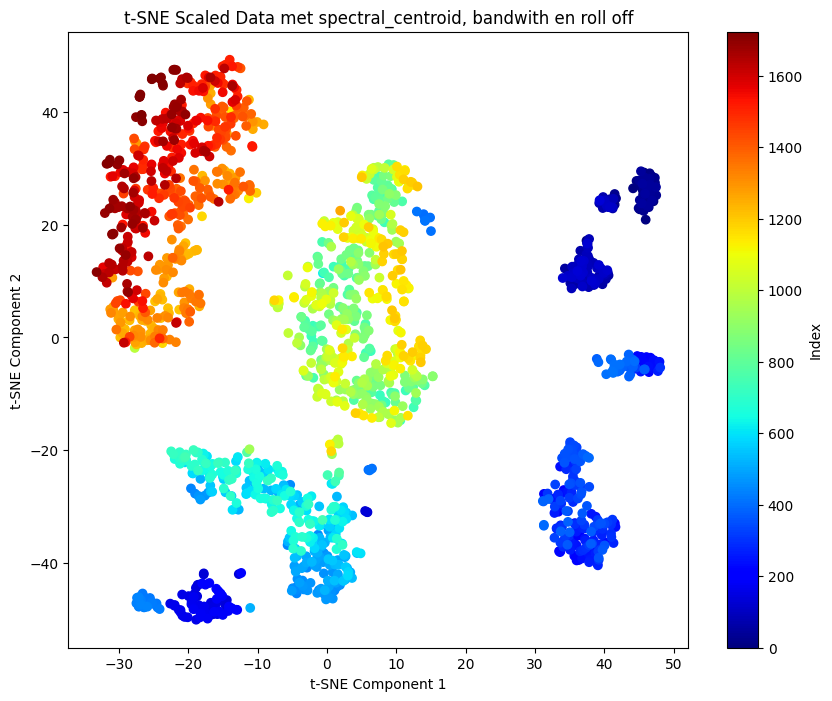

In [127]:
## Met spectral_centroid, bandwidth en roll off
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vert)

tsne = TSNE(n_components=2, random_state=42)
tsne_data_met = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_data_met[:, 0], tsne_data_met[:, 1], c=df['index'], cmap='jet')
plt.colorbar(scatter, label='Index')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scaled Data met spectral_centroid, bandwith en roll off')
plt.show()


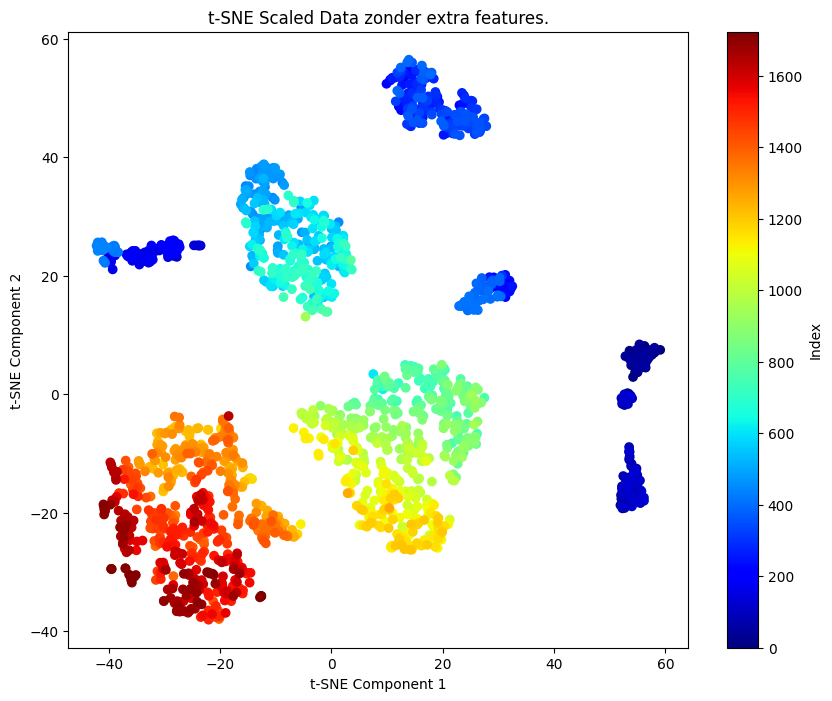

In [128]:
## Zonder spectral_centroid, bandwidth en roll off
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vert_zonder)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_scaled)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=df['index'], cmap='jet')
plt.colorbar(scatter, label='Index')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scaled Data zonder extra features.')
plt.show()


## 3b

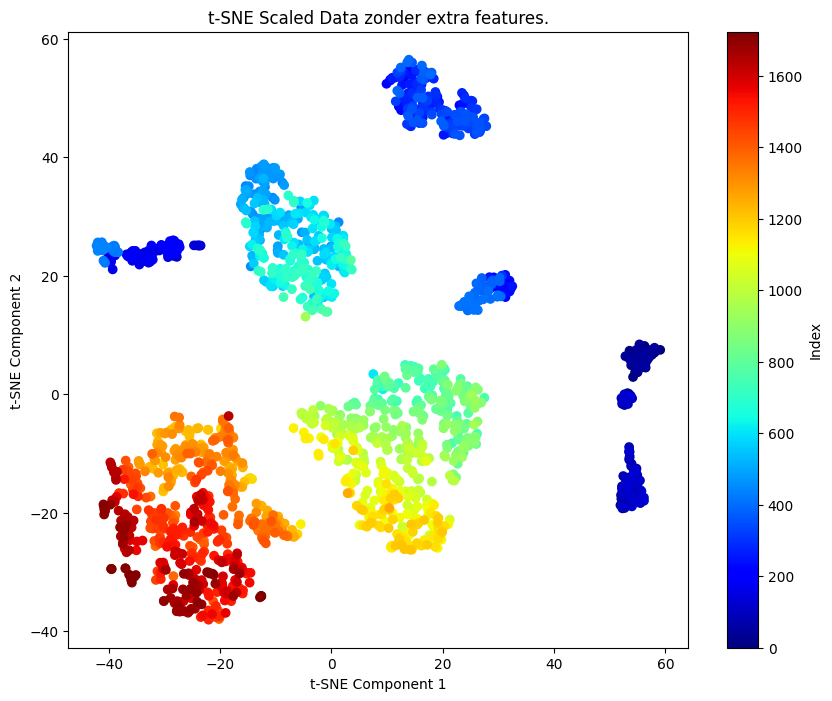

In [129]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vert_zonder)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_scaled)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=df['index'], cmap='jet')
plt.colorbar(scatter, label='Index')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scaled Data zonder extra features.')
plt.show()

Allereerst lijken er 3 hele duidelijk clusters te ontstaan, en een paar losse kleinere clusters. Deze losse kleinere clusters zijn allemaal vroege samples. De latere samples vormen duidelijkere clusters.

In [130]:
X_vert_zonder.describe()

,mean_y,rms_y,spectral_flatness_y,sample_entropy_y,index
count,1724.000000,1724.000000,1724.000000,1724.000000,1724.000000
mean,-0.115643,0.145915,0.151507,2.063831,861.500000
std,0.005987,0.007574,0.008737,0.032504,497.820249
min,-0.122835,0.116833,0.125028,1.950233,0.000000
25%,-0.117818,0.146431,0.146789,2.046151,430.750000
50%,-0.117219,0.148002,0.151030,2.063045,861.500000
75%,-0.116570,0.149113,0.155684,2.081142,1292.250000
max,-0.093747,0.159427,0.194549,2.155563,1723.000000


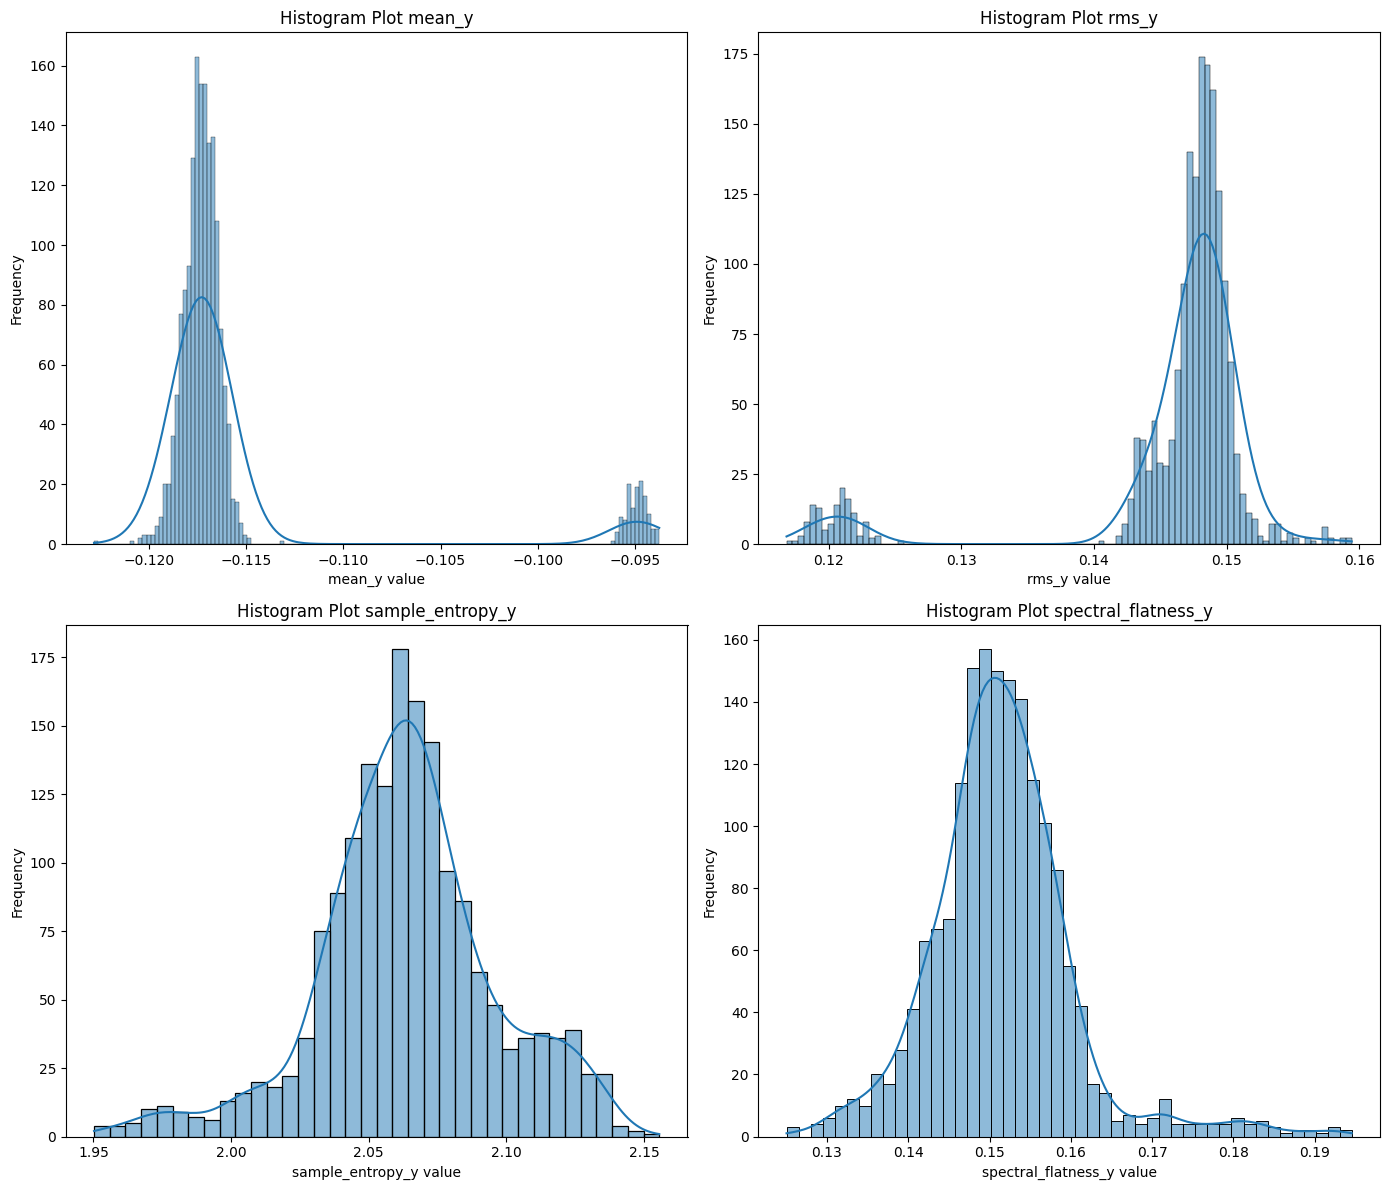

In [136]:
num_features = len(X_vert_zonder.columns.difference(['index']))
n_cols = 2
n_rows = (num_features + 1) // n_cols  # +1 to handle odd number of features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(X_vert_zonder.columns.difference(['index'])):
    # Plot the histogram for the current feature
    sns.histplot(df[feature], ax=axes[i], kde=True)  # Add kde=True for a density plot if desired
    axes[i].set_title(f'Histogram Plot {feature}')
    axes[i].set_xlabel(f'{feature} value')
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of features is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

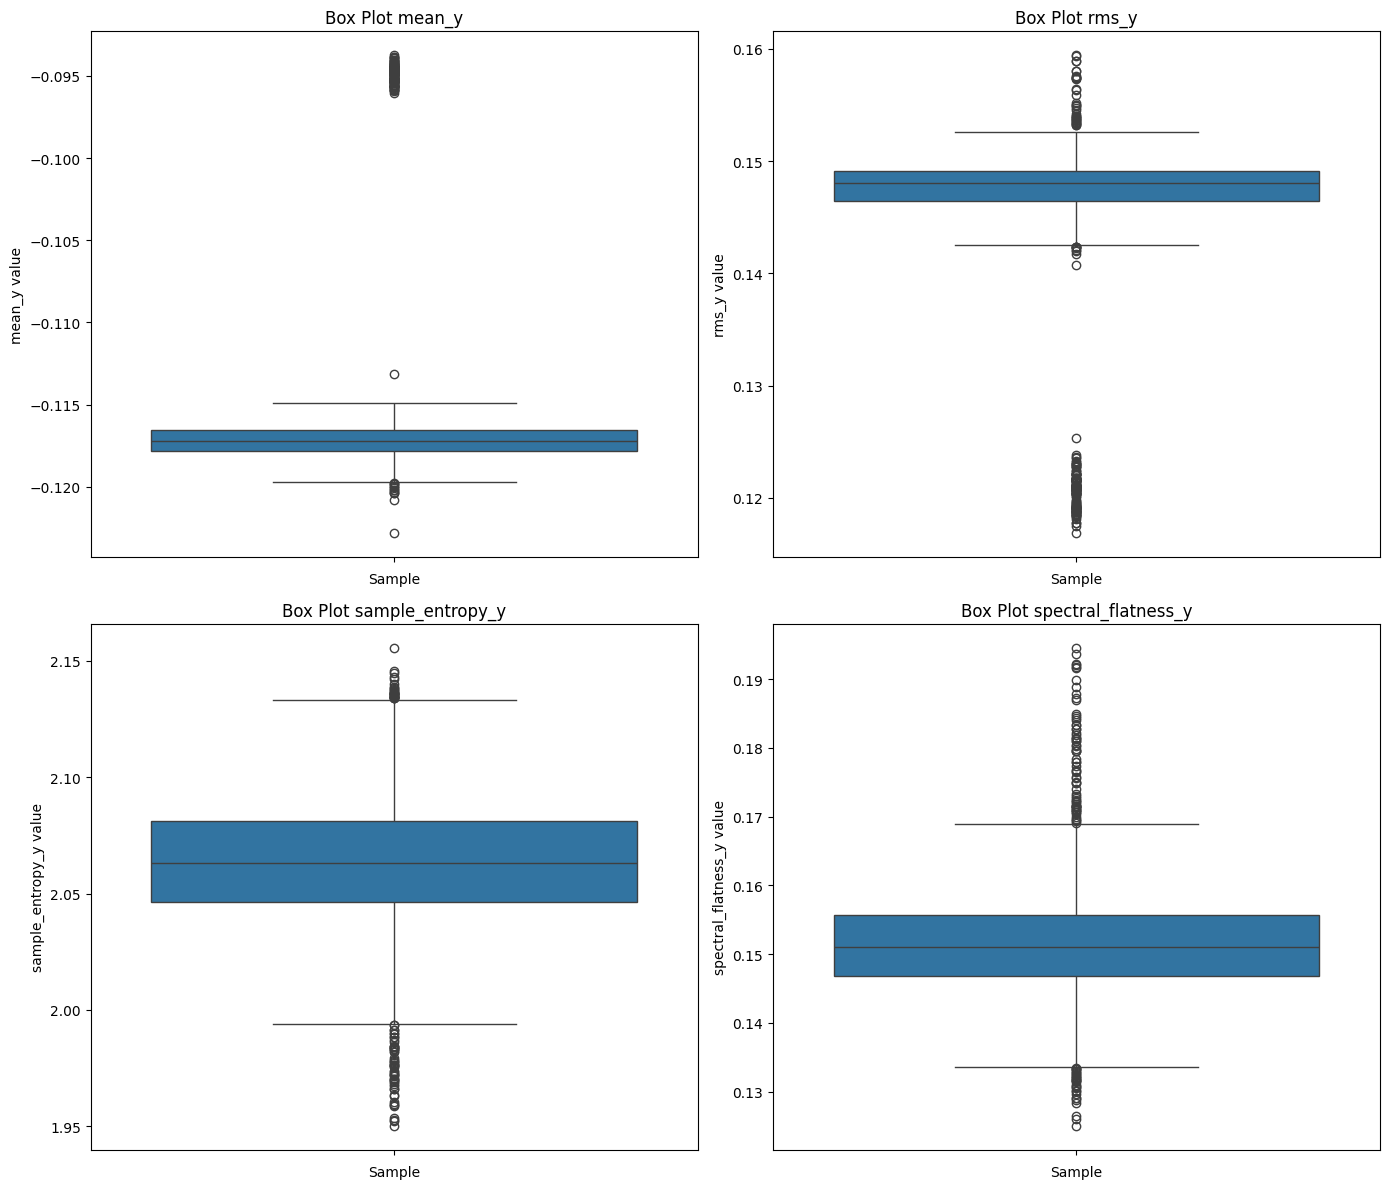

In [137]:
# Define the number of rows and columns for the subplot grid
num_features = len(X_vert_zonder.columns.difference(['index']))
n_cols = 2
n_rows = (num_features + 1) // n_cols  # +1 to handle odd number of features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(X_vert_zonder.columns.difference(['index'])):
    # Plot the box plot for the current feature
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot {feature}')
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel(f'{feature} value')

# Remove empty subplots if the number of features is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

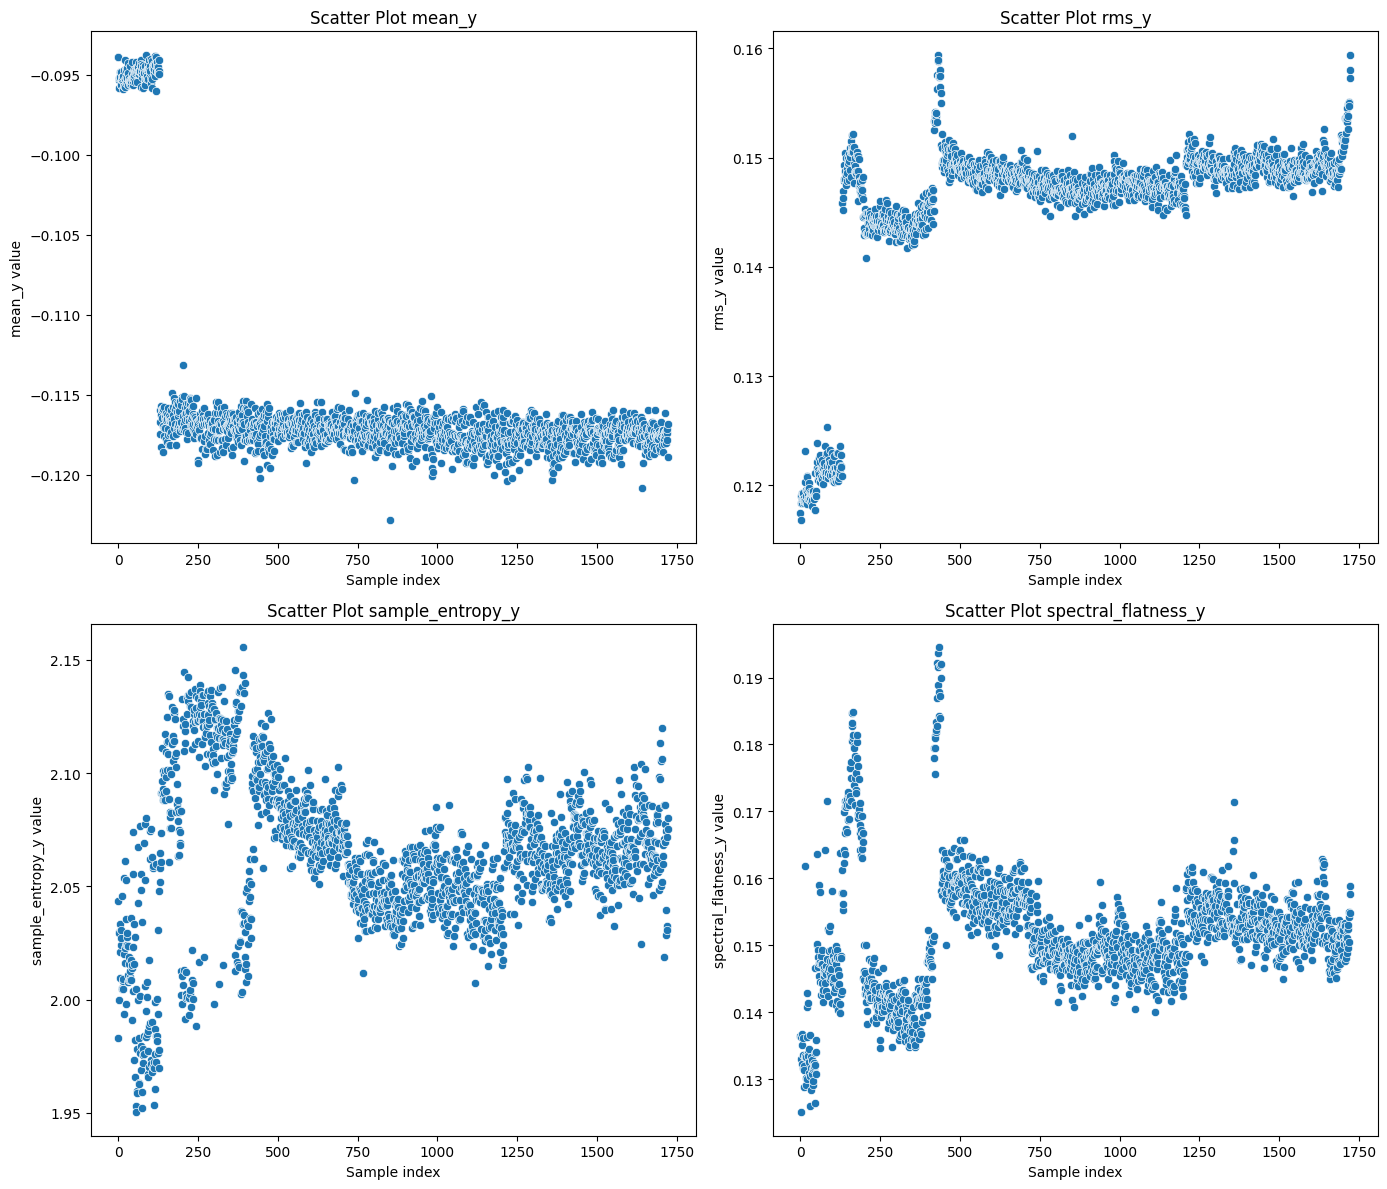

In [138]:
num_features = len(X_vert_zonder.columns.difference(['index']))
n_cols = 2
n_rows = (num_features + 1) // n_cols  # +1 to handle odd number of features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))

axes = axes.flatten()

for i, feature in enumerate(X_vert_zonder.columns.difference(['index'])):
    sns.scatterplot(x='index', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Scatter Plot {feature}')
    axes[i].set_xlabel('Sample index')
    axes[i].set_ylabel(f'{feature} value')

# Remove empty subplots if the number of features is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In de plotjes hierboven kunnen we duidelijk zien dat er tussen hogere en lagere index waardes er andere feature waardes horen. Dit is vooral heel duidelijk bij het begin van de mean, en RMS. Verder zien we bij de sample entropy een licht afnemende trend als je voorbij de 400 index kijkt. Met een verhoogd plateau aan het einde vanaf ongeveer 1300. En hetzelfde geldt voor de spectral flatness waar er ook vanaf ongeveer index 400 een dalende trend is met 2 vrij duidelijke plotselinge verhogingen. Onder index 400 bij de spectral flatness en sample entropy is er een grote variatie aan waardes. Dit verklaard ook onze t-SNE plot waar de lagere index waarde clusters alle kanten op te lijken gaan. Met de scatter plots lijken er 3 á 4 clusters te zijn, waarbij de losse kleinere clusters bij elkaar horen.

## 3c

#### Extra plot met b4 data

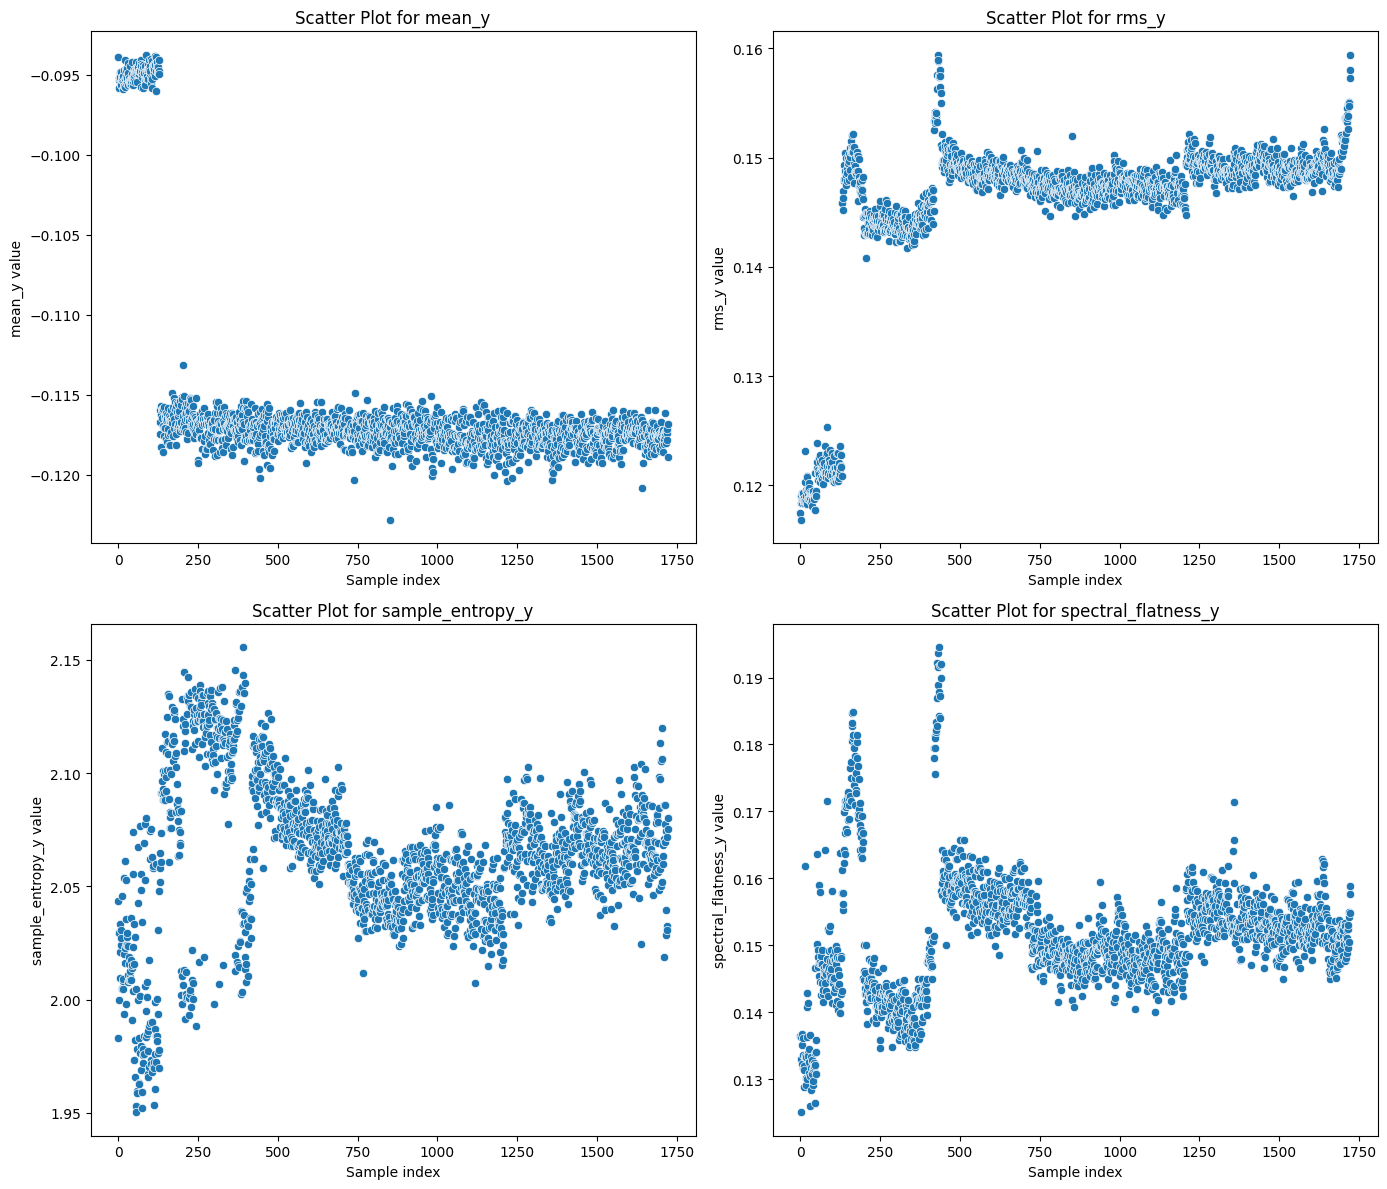

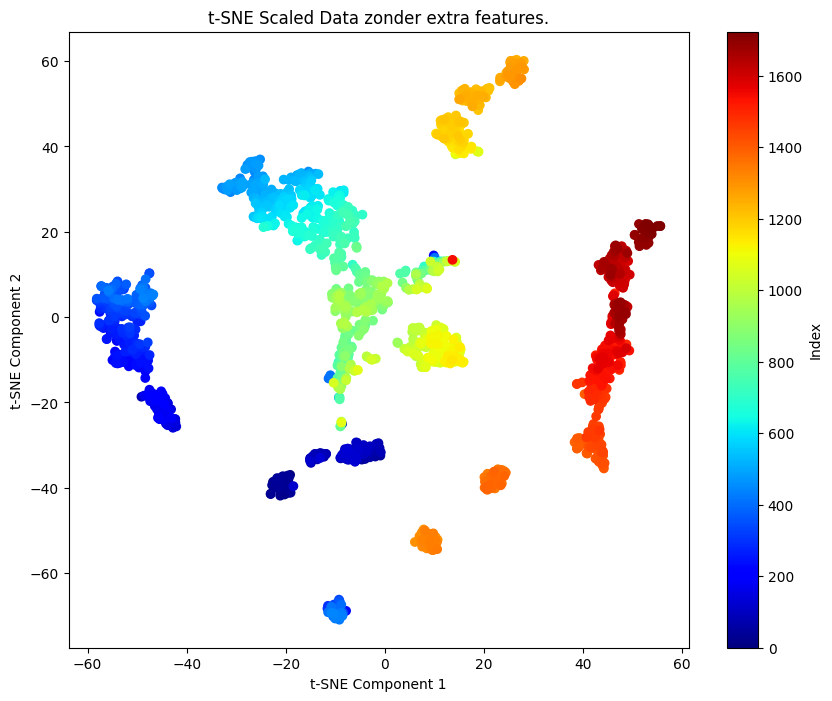

In [78]:
dataset = pd.read_excel('dataset_features.xlsx')
X_vert_zonder = dataset[['mean_y', 'rms_y', 'spectral_flatness_y', 'sample_entropy_y', 'index']]

num_features = len(X_vert_zonder.columns.difference(['index']))
n_cols = 2
n_rows = (num_features + 1) // n_cols  # +1 to handle odd number of features

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))

axes = axes.flatten()

for i, feature in enumerate(X_vert_zonder.columns.difference(['index'])):
    sns.scatterplot(x='index', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Scatter Plot for {feature}')
    axes[i].set_xlabel('Sample index')
    axes[i].set_ylabel(f'{feature} value')

# Remove empty subplots if the number of features is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vert_zonder)

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200 , random_state=42)
tsne_data = tsne.fit_transform(X_scaled)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=df['index'], cmap='jet')
plt.colorbar(scatter, label='Index')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scaled Data zonder extra features.')
plt.show()

In [57]:
X_vert_zonder.columns.values

Index(['mean_y', 'rms_y', 'sample_entropy_y', 'spectral_flatness_y'], dtype='object')

C:\Users\fraps\AppData\Local\Temp\ipykernel_14812\2713242081.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


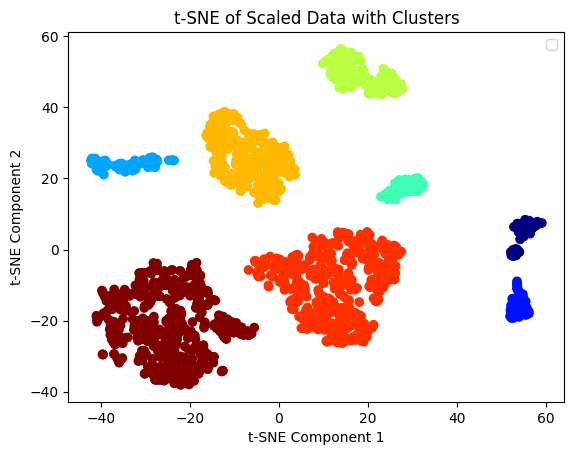

In [8]:
dbscan = DBSCAN(eps=4, min_samples=5)
clusters = dbscan.fit_predict(tsne_data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=clusters, cmap='jet')
plt.legend()
plt.title('t-SNE of Scaled Data with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [60]:
cluster_info = {}

# Iterate over unique clusters
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
    # Find indices of points in the current cluster
    indices = np.where(clusters == cluster)[0]
    
    # Calculate average index value
    avg_index = np.mean(indices)
    
    # Get total number of points in the cluster
    total_points = len(indices)
    
    # Store the results in the dictionary
    cluster_info[cluster] = {'average_index': avg_index, 'total_points': total_points}

# Display the cluster information
for key, item in cluster_info.items():
    

{0: {'average_index': 41.22727272727273, 'total_points': 66}, 1: {'average_index': 88.5, 'total_points': 64}, 2: {'average_index': 230.9777777777778, 'total_points': 90}, 3: {'average_index': 327.4032258064516, 'total_points': 62}, 4: {'average_index': 299.0440251572327, 'total_points': 159}, 5: {'average_index': 586.6597222222222, 'total_points': 288}, 6: {'average_index': 965.3122362869199, 'total_points': 474}, 7: {'average_index': 1461.9769673704416, 'total_points': 521}}


### Clustering

#### Epsilon optimalisatie.

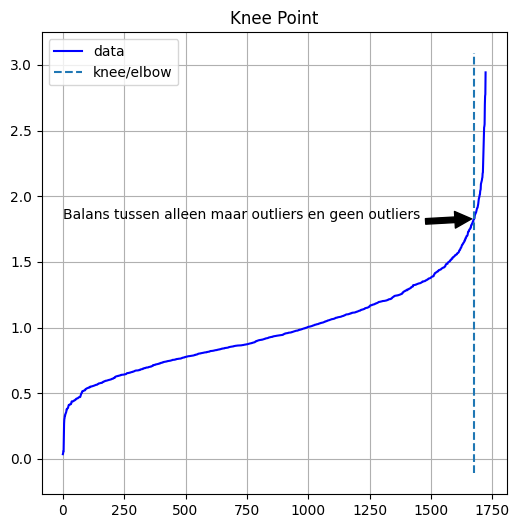

In [113]:
df = pd.read_excel('dataset_features_b1.xlsx')
data = df[['mean_y', 'rms_y', 'spectral_flatness_y', 'sample_entropy_y', 'index']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vert_zonder)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_scaled)

minimum_number_of_samples = 2*tsne_data.shape[1] 

nearest_neighbors = NearestNeighbors(n_neighbors = minimum_number_of_samples)
neighbours = nearest_neighbors.fit(tsne_data)
distances, _ = neighbours.kneighbors(tsne_data)

distances = np.sort(distances[:, minimum_number_of_samples - 1], axis = 0)

kl = KneeLocator(np.arange(len(distances)), distances, curve="convex")
kl.plot_knee()
xarrow = list(kl.all_elbows)[0]
yarrow = list(kl.all_elbows_y)[0]
plt.annotate('Balans tussen alleen maar outliers en geen outliers', 
             xy = (xarrow, yarrow), xytext = (0, yarrow), arrowprops=dict(facecolor='black', shrink=0.05))

plt.grid()

Uit het elbow plotje lijkt $\epsilon = 1.8$ de meest optimale waarde voor de DBSCAN. Daarnaast nemen we een min_samples = 10 omdat we 5 features hebben en de vuistregel is dat de min_samples = 2 * aantal features.

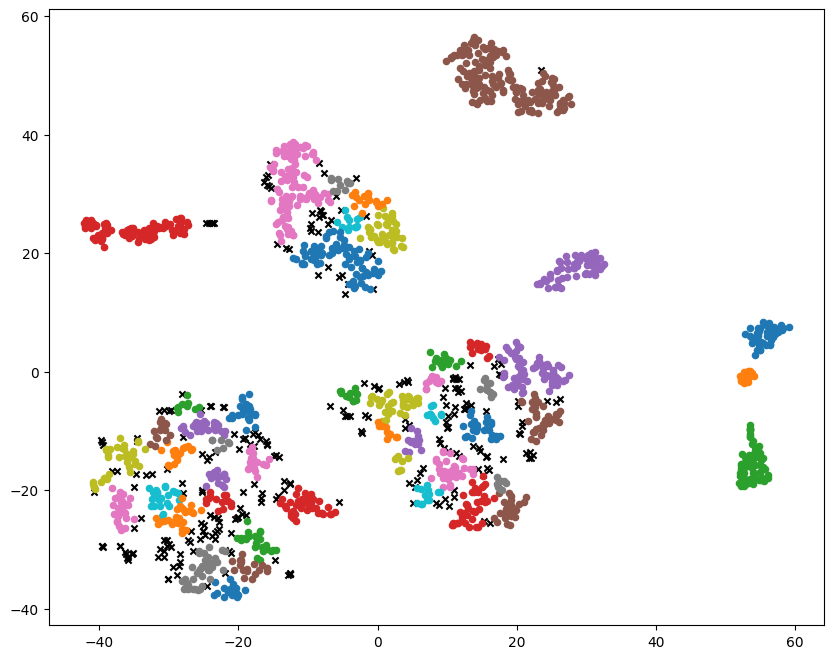

In [117]:
dbscan = DBSCAN(eps = 1.8, min_samples = 10)
clusters = dbscan.fit_predict(tsne_data)
plt.figure(figsize=(10, 8))
for i in np.unique(clusters):
    filter_cluster_i = clusters == i
    if i == -1:
        color = 'k'
        marker = 'x'
    else:
        color = None
        marker = 'o'
    
    plt.scatter(tsne_data[filter_cluster_i,0], tsne_data[filter_cluster_i,1], s=20, marker=marker, label = i, c=color)
    
plt.show()

Daar gaat iets niet helemaal goed, de epsilon moet omhoog omdat de grotere clusters een hogere variatie hebben dan de kleinere clusters, de grotere worden clusters in heel veel kleine clusters verdeeld. Als we de epsilon verhogen naar 4, hebben we dit probleem niet meer. Dit zorgt niet gekke dingen in de clusters omdat de grotere clusters ver genoeg uit elkaar liggen dat ze zich niet combineren met elkaar.

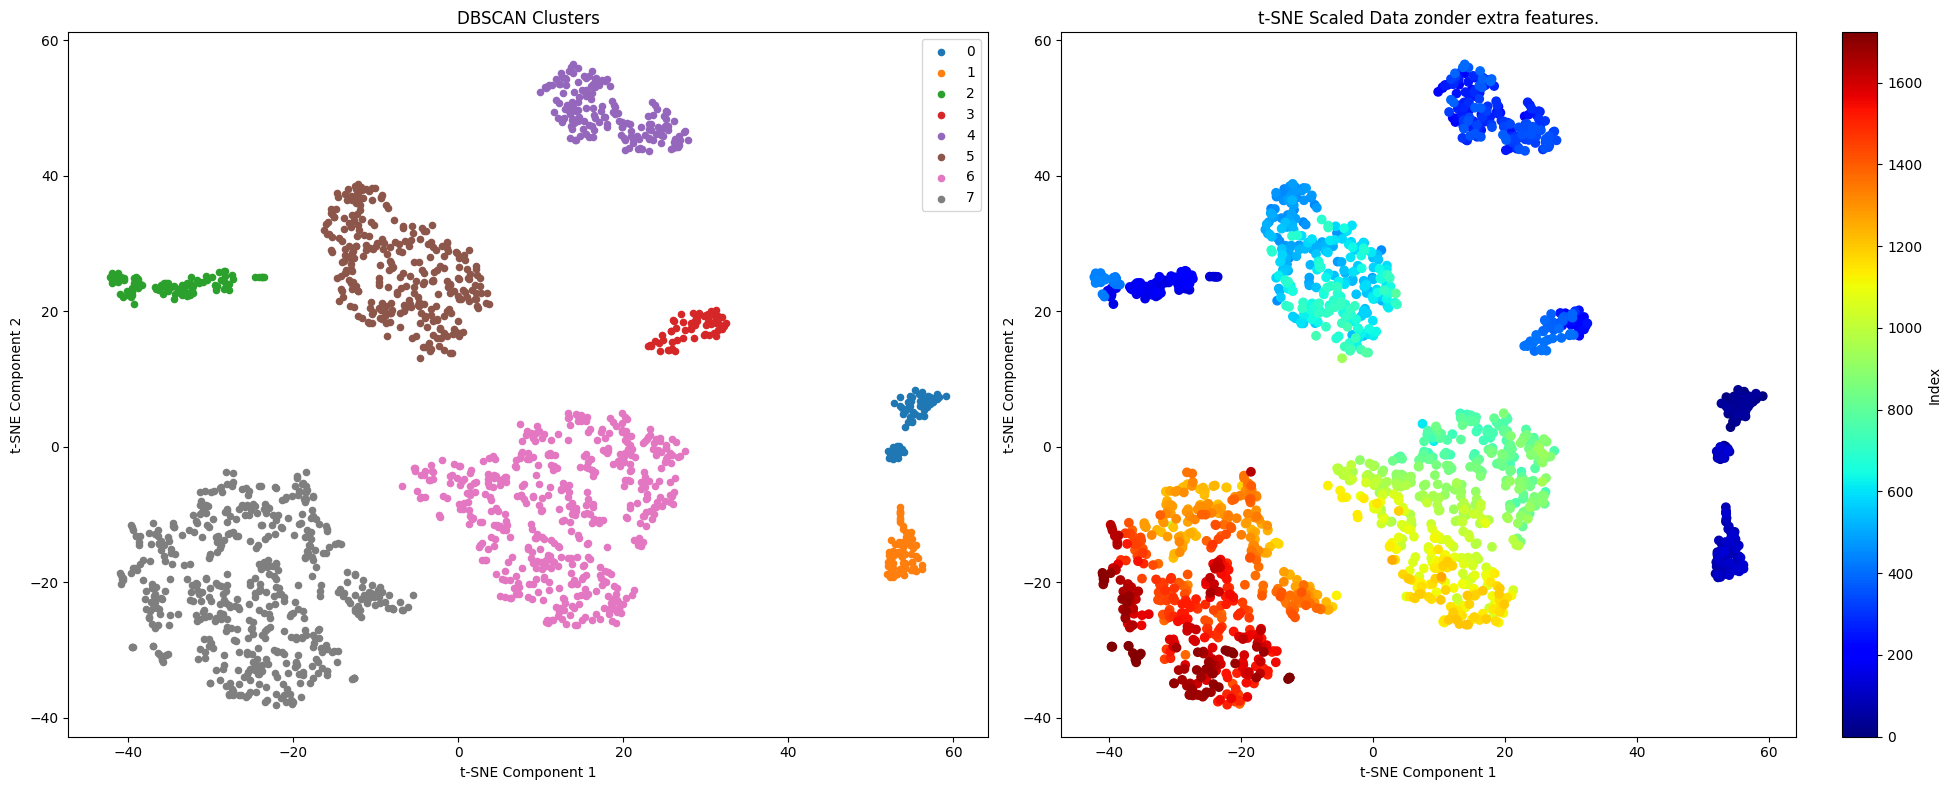

In [118]:
dbscan = DBSCAN(eps=4, min_samples=10)
clusters = dbscan.fit_predict(tsne_data)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot the DBSCAN clusters
for i in np.unique(clusters):
    filter_cluster_i = clusters == i
    if i == -1:
        color = 'k'
        marker = 'x'
    else:
        color = None
        marker = 'o'
    
    axs[0].scatter(tsne_data[filter_cluster_i, 0], tsne_data[filter_cluster_i, 1], s=20, marker=marker, label=i, c=color)

axs[0].legend()
axs[0].set_title('DBSCAN Clusters')
axs[0].set_xlabel('t-SNE Component 1')
axs[0].set_ylabel('t-SNE Component 2')

# Plot the t-SNE result
scatter = axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=df['index'], cmap='jet')
plt.colorbar(scatter, ax=axs[1], label='Index')
axs[1].set_xlabel('t-SNE Component 1')
axs[1].set_ylabel('t-SNE Component 2')
axs[1].set_title('t-SNE Scaled Data zonder extra features.')

# Show the combined plot
plt.tight_layout()
plt.show()

In [125]:
merged_clusters = clusters.copy()
merged_clusters[np.isin(clusters, [0, 1, 2, 3, 4])] = 0

# Dictionary to store cluster information
cluster_info = {}

unique_clusters = np.unique(merged_clusters)
for cluster in unique_clusters:
    indices = np.where(merged_clusters == cluster)[0]
    avg_index = np.mean(indices)
    total_points = len(indices)
    
    # Calculate average values of the features
    avg_mean_y = data.loc[indices, 'mean_y'].mean()
    avg_rms_y = data.loc[indices, 'rms_y'].mean()
    avg_spectral_flatness_y = data.loc[indices, 'spectral_flatness_y'].mean()
    avg_sample_entropy_y = data.loc[indices, 'sample_entropy_y'].mean()
    
    cluster_info[cluster] = {
        'average_index': avg_index,
        'total_points': total_points,
        'average_mean_y': avg_mean_y,
        'average_rms_y': avg_rms_y,
        'average_spectral_flatness_y': avg_spectral_flatness_y,
        'average_sample_entropy_y': avg_sample_entropy_y
    }

for cluster, info in cluster_info.items():
    print(f"Cluster {cluster}:")
    print(f"  Gemiddelde Index: {info['average_index']}")
    print(f"  Gemiddelde mean_y: {info['average_mean_y']}")
    print(f"  Gemiddelde rms_y: {info['average_rms_y']}")
    print(f"  Gemiddelde spectral_flatness_y: {info['average_spectral_flatness_y']}")
    print(f"  Gemiddelde sample_entropy_y: {info['average_sample_entropy_y']}")

Cluster 0:
  Gemiddelde Index: 220.0
  Gemiddelde mean_y: -0.11039816014296341
  Gemiddelde rms_y: 0.1384946845299009
  Gemiddelde spectral_flatness_y: 0.14870089537273024
  Gemiddelde sample_entropy_y: 2.0678589832928798
Cluster 5:
  Gemiddelde Index: 586.6597222222222
  Gemiddelde mean_y: -0.11711467776828341
  Gemiddelde rms_y: 0.14877641694128105
  Gemiddelde spectral_flatness_y: 0.15754515170882358
  Gemiddelde sample_entropy_y: 2.079929502287198
Cluster 6:
  Gemiddelde Index: 965.3122362869199
  Gemiddelde mean_y: -0.11745648723875923
  Gemiddelde rms_y: 0.14727261064210062
  Gemiddelde spectral_flatness_y: 0.1482824141751277
  Gemiddelde sample_entropy_y: 2.0467474004835835
Cluster 7:
  Gemiddelde Index: 1461.9769673704416
  Gemiddelde mean_y: -0.11762030659563939
  Gemiddelde rms_y: 0.1493796992483013
  Gemiddelde spectral_flatness_y: 0.15347652824738608
  Gemiddelde sample_entropy_y: 2.067063478759188


## 3d

Clusters interpretatie:

0, 1, 2, 3, 4: Deze clusters vormen het ruizige begin van een net nieuwe bearing die aan het werk is gezet.\
Stage naam: Nieuw

5: Dit cluster heeft een meer gedefinieerde grens, hier is de nieuwe bearing goed op gang gekomen en is heeft een meer voorspelbaar gedrag dan de net nieuw bearing. Heeft een bestwel puur signaal verdeeld over niet veel frequenties.\
Stage naam: Nieuw warmgedraaid.

6: Dit cluster heeft een nog meer voorspelbaar signaal en nu al een tijdje aan het draaien en het nieuwe is ervanaf.\
Stage naam: Normaal

7: Dit cluster begint weer iets onvoorspelbaarder te worden en de afwijkingen lijken ook omhoog te gaan. Deze stage begint de bearing verdacht te worden en zou binnenkort mogelijk kapot kunnen gaan. In dit stadium kun je de bearing beter vervangen voordat de bearing verder aftakelt. \
Stage naam: Verdacht